# Inspiral Frequency Model

This notebook creates the inspiral frequency model.

## Steps

0. Configs
    - output dir
    - ansatz
    - fit parameters
1. loads NR data and defines train/test split
2. Fit ansatz to each sample
3. Parameter space fit
4. model validation
5. save model (GPs)

# Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})

<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np
import os
import copy
import datetime
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# i tried joblib and dill to save the model but they didn't work
# because under the hood i used a sympy lambdify function
# this SO post solved my issue using cloudpickle.
# https://stackoverflow.com/a/31365136/12840171
import cloudpickle

In [3]:
# custom
import phenom
import workflow_utils
import pn

import collocation

In [4]:
import sympy
# sympy.init_printing()
# x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

# x_sym: generic name I use for independent variables for sympy
x_sym = sympy.symbols('x_sym')

# Config

In [5]:
target = 'freq'
region = 'inspiral'

tag = datetime.date.today().strftime("%d_%m_%y")

ROOT_DIR = "/Users/sebastian.khan/personal/data/gpm_model"
OUTPUT_DIR = f"{target}_{region}_{tag}"
OUTPUT_PATH = os.path.join(ROOT_DIR, OUTPUT_DIR)

print(f"{OUTPUT_DIR = }")
print(f"{OUTPUT_PATH = }")

OUTPUT_DIR = 'freq_inspiral_03_03_23'
OUTPUT_PATH = '/Users/sebastian.khan/personal/data/gpm_model/freq_inspiral_03_03_23'


In [6]:
os.makedirs(OUTPUT_PATH, exist_ok=False)

In [7]:
# TaylorT3 PN parameters
tc=0 # doesn't work so well for high q
# tc=100 # reasonable compromise
# tc=1000 # doesn't recover T3 for early times
M=1

# Time range avaiable to use for fitting and testing
pad = 10
t_start = -700 - pad
t_end = -100 + pad

# can choose to resample or not
# dt = 0.1
dt = None

## DEFINE ANSATZ

base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10])
# base_ansatz = np.sum([x_sym**8, x_sym**9, x_sym**10, x_sym**11])
collocation_points = {
    # 0:[-700, -500, -300],
    0:[-700, -300, -100],
    # 0:[-700, -500, -200],
    # 0:[-700, -500, -300, -200],
    # 1:[-300],
}

# Load NR

In [8]:
data_dict = workflow_utils.load_nr_data()

# test_set_query='(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10) or (q>=14 and q<16)'
# data_dict = workflow_utils.load_nr_data(test_set_query=test_set_query)



In [9]:
data_dict['train_idxs']

Int64Index([ 0,  4,  6,  8, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26,
            27, 31, 35, 37, 38, 46, 51, 53],
           dtype='int64')

In [10]:
data_dict['test_idxs']

Int64Index([ 1,  2,  3,  5,  7,  9, 11, 14, 24, 25, 28, 29, 30, 32, 33, 34, 36,
            39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 52],
           dtype='int64')

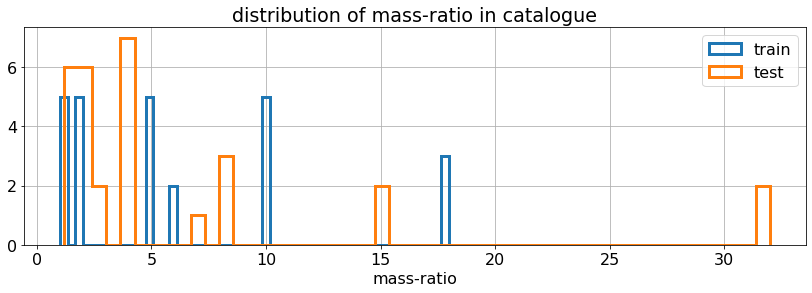

In [11]:
plt.figure(figsize=(14, 4))
plt.hist(data_dict['df']['q'][data_dict['train_idxs']], bins=50, histtype='step', lw=3, label='train')
plt.hist(data_dict['df']['q'][data_dict['test_idxs']], bins=50, histtype='step', lw=3, label='test')
plt.legend()
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

In [12]:
waveforms = [
    workflow_utils.Waveform(
        strain=data_dict['strains'][i],
        times=data_dict['times'],
        amp=data_dict['amps'][i],
        phase=data_dict['phases'][i],
        freq=data_dict['freqs'][i],
        q=data_dict['df']['q'].values[i],
        meta_data=data_dict['df'].loc[[i]],
    )
    for i in range(len(data_dict['df']))]

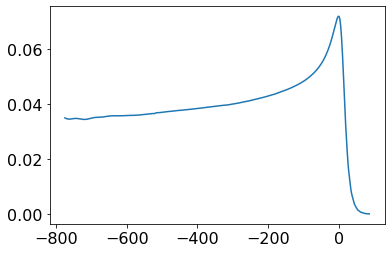

In [13]:
plt.plot(waveforms[0].times, waveforms[0].amp)

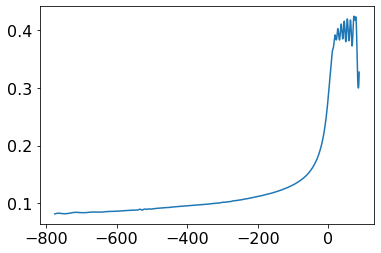

In [14]:
plt.plot(waveforms[0].times, waveforms[0].freq)

# Fit ansatz

In [15]:

# wcfs: Waveform Collocation Fitter objects
wcfs = []
# list of TaylorT3 Newtonian term for each sample
omega_Ns = []
# list of TaylorT3 full PN for each sample
omega_pns = []


for i in range(len(data_dict['df'])):
    q = data_dict['df'].iloc[i]['q']
    name = data_dict['df'].iloc[i]['name']
    set_member = data_dict['df'].iloc[i]['set']
    print(f"working: {i} ({set_member}): q={q} \t {name}")
    
    eta = phenom.eta_from_q(q)
    
    # get data to fit
    t_, y_ = workflow_utils.prepare_fit_data(
        waveform=waveforms[i],
        t_start=t_start,
        t_end=t_end,
        target=target,
        dt=dt,
    )
    
    # PN parameters
    pn_kwargs=dict(t=t_, tc=tc, eta=eta, M=M)

    # Get PN transformation variables
    omega_N, omega_pn = workflow_utils.get_taylort3_inspiral_omega_affine_params(t_, tc, eta, M)
    
    # apply tranformation
    y_transformed = workflow_utils.transformation_affine_reverse(y_, omega_N, omega_pn)
    
    # prepare ansatz
    theta = pn.TaylorT3_theta(x_sym, tc, eta, M)
    pn_sub_dict = {'x_sym': theta }
    ansatz = base_ansatz.subs(pn_sub_dict)
    sub_dict={}
    
    wcf = workflow_utils.WaveformCollocationFitter(
        t_,
        y_transformed,
        collocation_points,
        ansatz,
        sub_dict,
    )

    omega_Ns.append(omega_N)
    omega_pns.append(omega_pn)
    wcfs.append(wcf)

working: 0 (train): q=18.0 	 q18a0a0c025_96_fine
working: 1 (test): q=4.0 	 q4a0_T_96_384
working: 2 (test): q=8.0 	 q8a0a0_T_96_504n512
working: 3 (test): q=8.0 	 q8a0a0c05_T_80_420
working: 4 (train): q=10.0 	 q10c25e_T_112_448
working: 5 (test): q=4.0 	 q4a0_T_80_320
working: 6 (train): q=18.0 	 q18a0a0c025_144
working: 7 (test): q=8.0 	 q8a0a0_T_112_588n768
working: 8 (train): q=18.0 	 q18a0a0c025_120
working: 9 (test): q=4.0 	 q4a0_T_112_448
working: 10 (train): q=5.0 	 SXS_BBH_0107_Res3
working: 11 (test): q=4.0 	 SXS_BBH_0167_Res5
working: 12 (train): q=5.0 	 SXS_BBH_0107_Res5
working: 13 (train): q=5.0 	 SXS_BBH_0107_Res4
working: 14 (test): q=4.0 	 SXS_BBH_0167_Res3
working: 15 (train): q=2.0 	 SXS_BBH_0169_Res4
working: 16 (train): q=2.0 	 SXS_BBH_0169_Res5
working: 17 (train): q=2.0 	 SXS_BBH_0169_Res3
working: 18 (train): q=1.0 	 SXS_BBH_0180_Res3
working: 19 (train): q=10.0 	 SXS_BBH_0303_Res3
working: 20 (train): q=1.0 	 SXS_BBH_0180_Res2
working: 21 (train): q=10.0 	 SXS

In [16]:
titles_ = []
y0s_ = []
y1s_ = []
pns_ = []
for i in range(len(data_dict['df'])):
    title_ = data_dict['df']['tag'][i]
    y0_ = workflow_utils.transformation_affine_foward(wcfs[i].y, omega_Ns[i], omega_pns[i])
    y1_ = workflow_utils.transformation_affine_foward(wcfs[i].cm.predict(wcfs[i].x), omega_Ns[i], omega_pns[i])
    pn_ = omega_pns[i]
    
    titles_.append(title_)
    y0s_.append(y0_)
    y1s_.append(y1_)
    pns_.append(pn_)

y0s_ = np.array(y0s_)
y1s_ = np.array(y1s_)
pns_ = np.array(pns_)

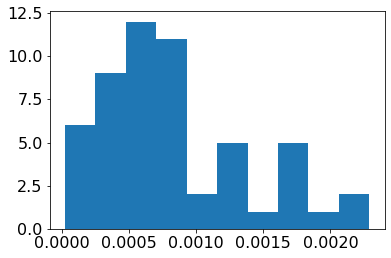

In [17]:
plt.hist(np.max(np.abs(y0s_ - y1s_), 1));

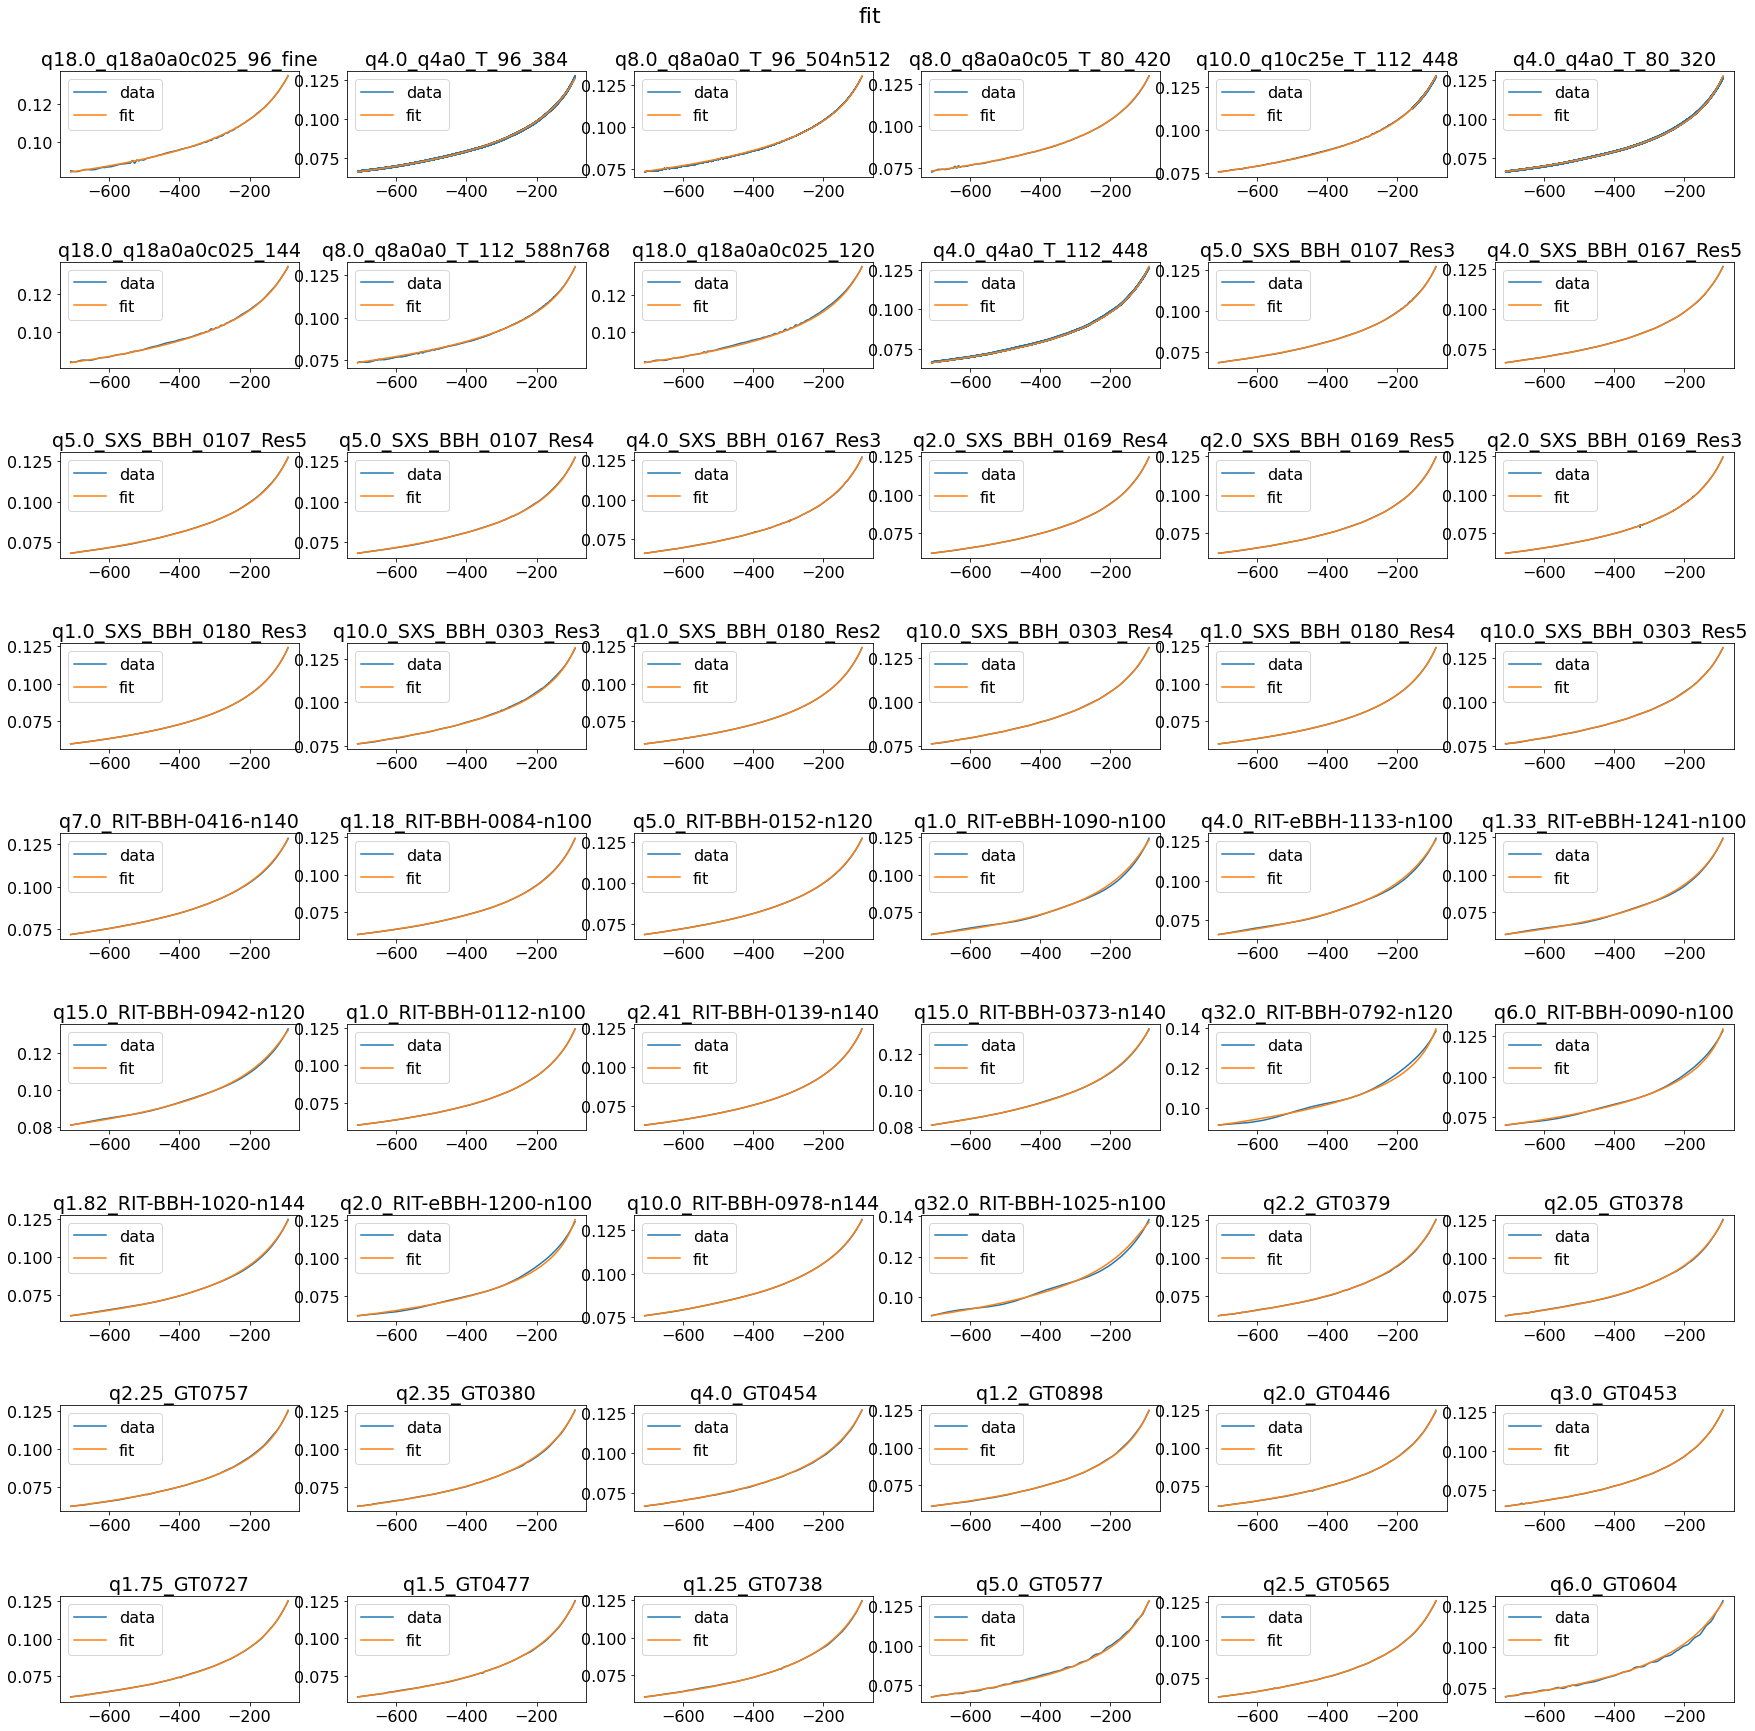

In [18]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_, y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data','fit'], suptitle="fit")

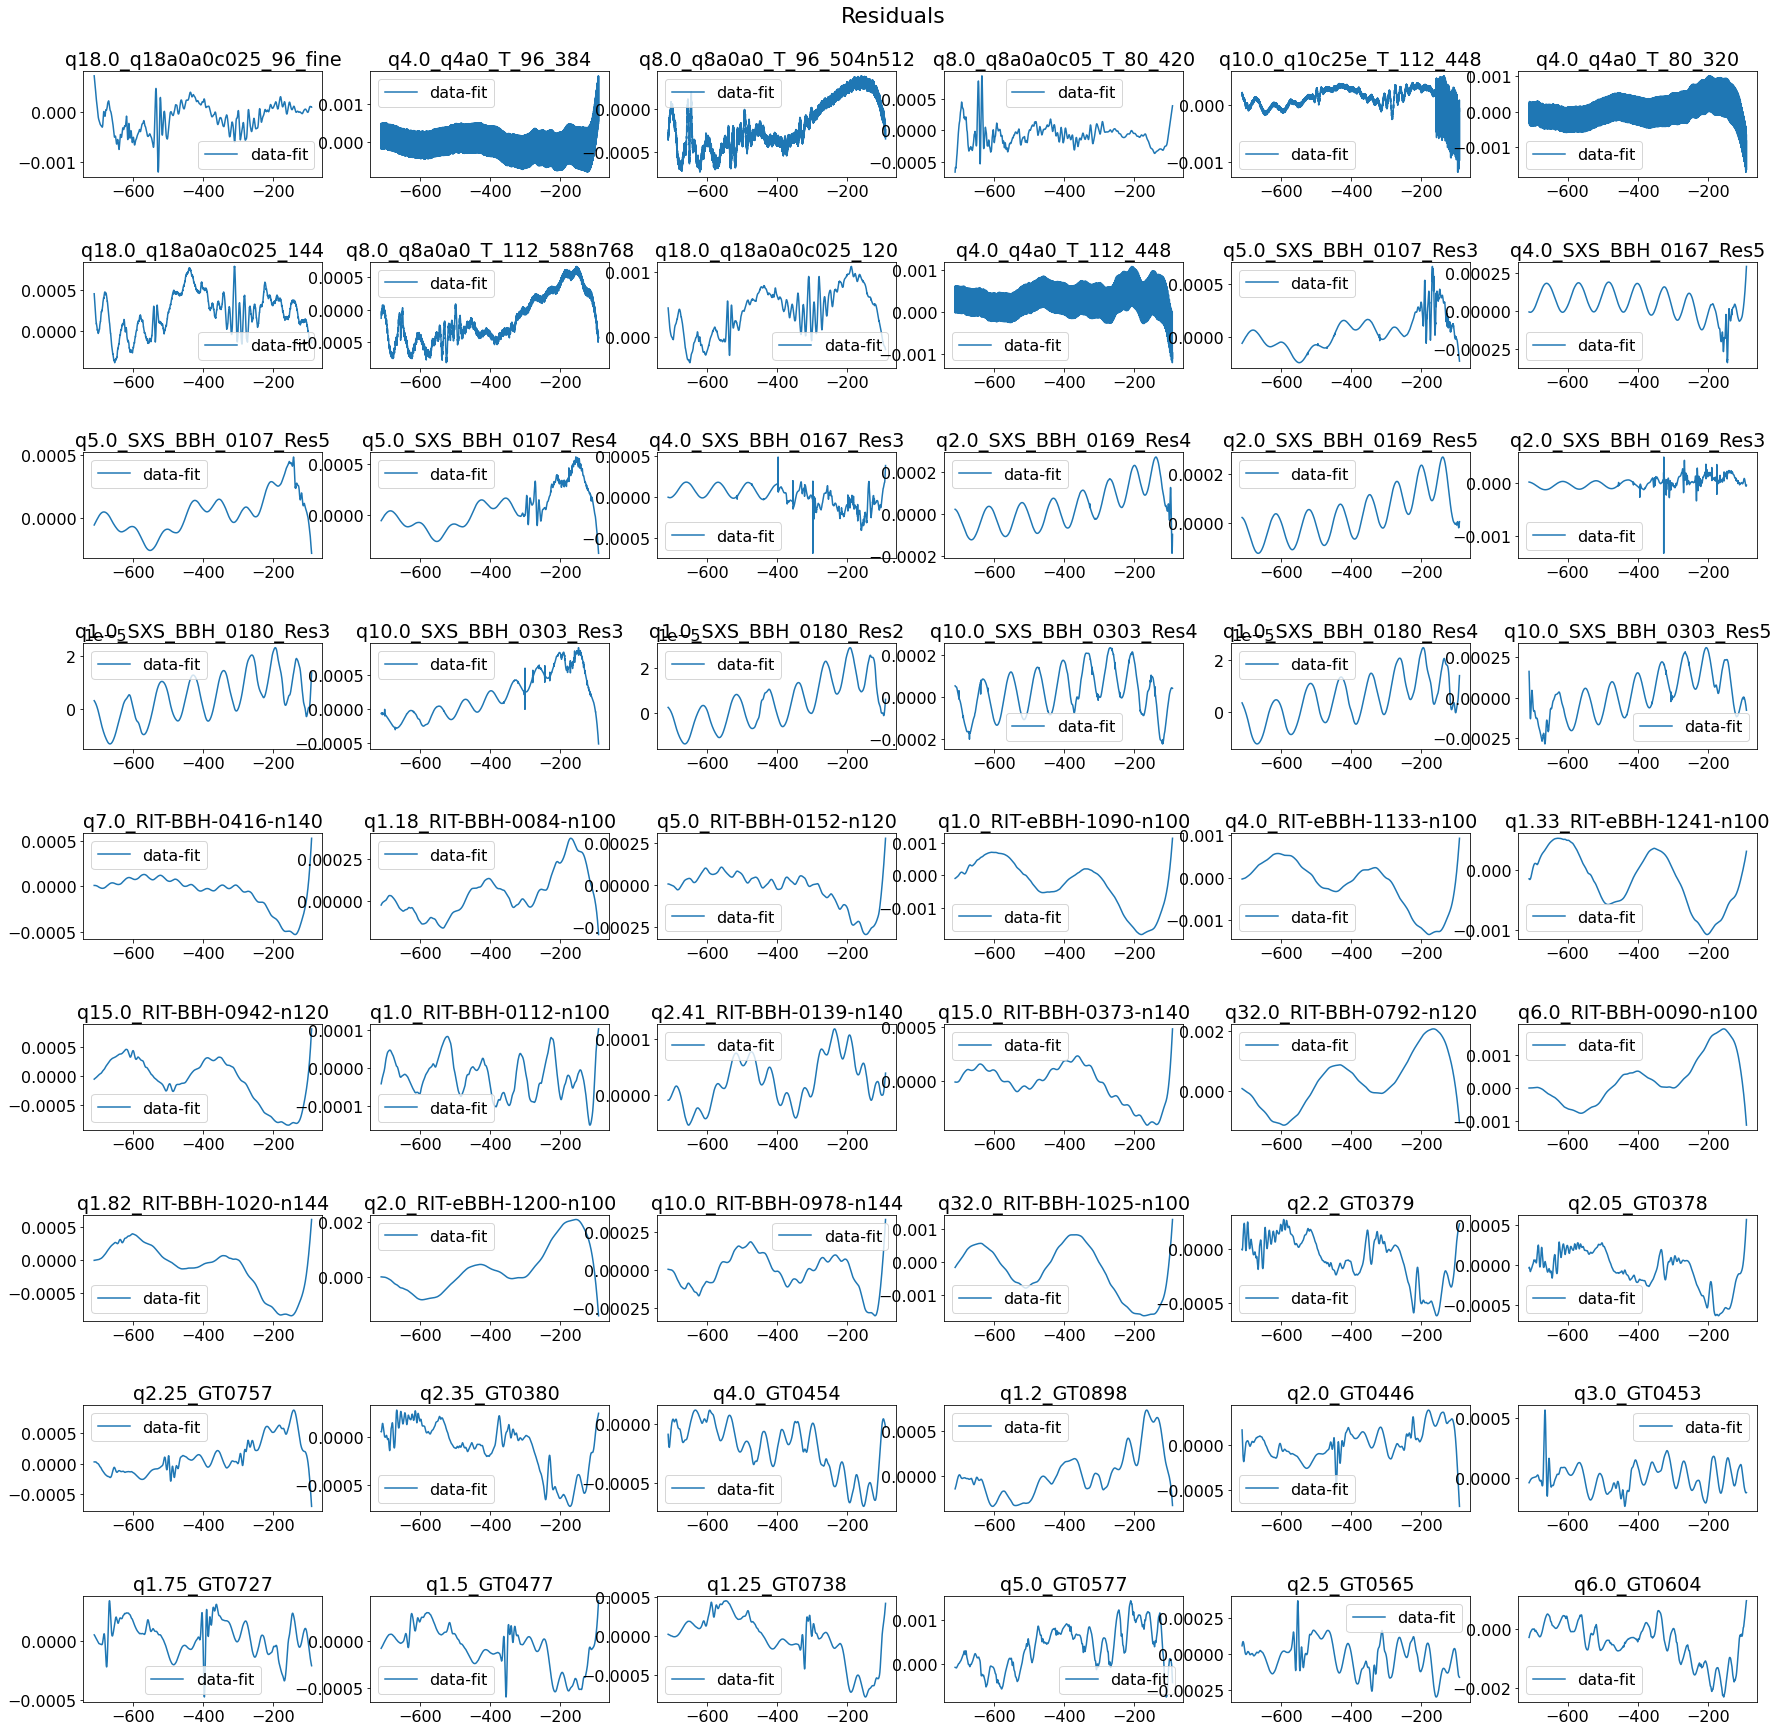

In [19]:
workflow_utils.plot_grid(xs=wcfs[0].x, ys=np.array([y0s_ - y1s_]), ncols=6, figsize=(30, 30), titles=titles_, label=['data-fit'], suptitle="Residuals")

# parameter space fits

## build train/test set for parameter space fits

In [20]:
# use these as the column names
# for the train/test set dataframes
# they correspond to the derivative-order
# and collocation point
tags = wcfs[0].cm.tags
tags

['d0_c0', 'd0_c1', 'd0_c2']

In [21]:
df_psf_x = data_dict['df']['q']

In [22]:
df_psf_y = pd.DataFrame(np.array([w.cm.rhs_1d for w in wcfs]), columns=tags)

In [23]:
df_psf_x_train = df_psf_x.iloc[data_dict['train_idxs']]
df_psf_y_train = df_psf_y.iloc[data_dict['train_idxs']]

In [24]:
df_psf_x_test = df_psf_x.iloc[data_dict['test_idxs']]
df_psf_y_test = df_psf_y.iloc[data_dict['test_idxs']]

In [25]:
df_psf_y

d0_c0     d0_c1     d0_c2
0   0.692323  1.438972  3.579496
1   0.231071  0.496360  1.251387
2   0.372256  0.774847  1.962402
3   0.359727  0.770440  1.964258
4   0.427591  0.906361  2.303383
5   0.235073  0.490386  1.263239
6   0.689122  1.434868  3.577320
7   0.374349  0.774232  1.961443
8   0.688975  1.431866  3.578094
9   0.230171  0.490188  1.260511
10  0.264856  0.557719  1.430075
11  0.228029  0.490629  1.255772
12  0.265252  0.557955  1.430696
13  0.265958  0.557566  1.430588
14  0.227571  0.491432  1.256515
15  0.170075  0.357423  0.913045
16  0.170108  0.357370  0.913439
17  0.170192  0.358205  0.913134
18  0.151924  0.321508  0.816878
19  0.435516  0.906868  2.301450
20  0.152041  0.321498  0.816839
21  0.432287  0.910441  2.301897
22  0.151886  0.321475  0.816881
23  0.433268  0.909919  2.302150
24  0.325615  0.701181  1.783491
25  0.154692  0.321956  0.822244
26  0.264106  0.562283  1.427666
27  0.143254  0.331332  0.821311
28  0.224949  0.497291  1.257196
29  0.153080  0.333060  0.839223
30  0.590402  1.245046  3.111347
31  0.147092  0.317618  0.818619
32  0.179812  0.382013  0.975247
33  0.592256  1.243675  3.111811
34  1.113044  2.265875  5.566891
35  0.300800  0.620075  1.608548
36  0.159558  0.353403  0.889840
37  0.180667  0.348026  0.912078
38  0.429171  0.909991  2.300820
39  1.104698  2.273077  5.565105
40  0.178776  0.380456  0.954922
41  0.173300  0.372062  0.928674
42  0.184821  0.376020  0.960745
43  0.181295  0.389517  0.978441
44  0.234780  0.498866  1.261753
45  0.164837  0.331175  0.834410
46  0.176295  0.361711  0.916772
47  0.203278  0.427297  1.084595
48  0.167766  0.352255  0.890866
49  0.161492  0.345028  0.858812
50  0.152987  0.334946  0.836781
51  0.253084  0.548578  1.438407
52  0.187406  0.396185  1.001156
53  0.293944  0.640854  1.613987

In [26]:
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(np.log(df_psf_x_train), np.log(df_psf_y_train[col]), 'o', label='train')
    ax.plot(np.log(df_psf_x_test), np.log(df_psf_y_test[col]), 'x', label='test')
    ax.set_title(col)
    if i == 0:
        ax.legend()

In [27]:
alphas = workflow_utils.compute_alphas(df_psf_x_train, df_psf_y_train)

In [28]:
alphas

{'d0_c0': array([0.00189192, 0.00318436, 0.00189192, 0.00189192, 0.00538995,
        0.00538995, 0.00538995, 0.00483088, 0.00483088, 0.00483088,
        0.00395279, 0.00318436, 0.00395279, 0.00318436, 0.00395279,
        0.00318436, 0.00538995, 0.00395279, 0.00395279, 0.00484731,
        0.00483088, 0.00318436, 0.00483088, 0.00538995, 0.00484731]),
 'd0_c1': array([0.00356742, 0.00193693, 0.00356742, 0.00356742, 0.00501068,
        0.00501068, 0.00501068, 0.00508572, 0.00508572, 0.00508572,
        0.00511636, 0.00193693, 0.00511636, 0.00193693, 0.00511636,
        0.00193693, 0.00501068, 0.00511636, 0.00511636, 0.0146933 ,
        0.00508572, 0.00193693, 0.00508572, 0.00501068, 0.0146933 ]),
 'd0_c2': array([0.0011031 , 0.00095156, 0.0011031 , 0.0011031 , 0.00405934,
        0.00405934, 0.00405934, 0.00179473, 0.00179473, 0.00179473,
        0.00194609, 0.00095156, 0.00194609, 0.00095156, 0.00194609,
        0.00095156, 0.00405934, 0.00194609, 0.00194609, 0.00384616,
        0.0017947

In [29]:
# we need to store the sign of the data so that
# we can reverse a log(abs(x)) transformation
signs_dict = df_psf_y_train.apply(lambda x: np.sign(x)).iloc[[0]]
signs_dict

d0_c0  d0_c1  d0_c2
0    1.0    1.0    1.0

In [30]:
# loop over a fit
gps={}
for col in df_psf_y_train.columns:
    print(f"working: {col}")
    GaussianProcessRegressor_kwargs=dict(
        kernel=Matern(nu=2.5) * ConstantKernel() + DotProduct() * ConstantKernel(),
        # kernel=Matern(nu=2.5) * ConstantKernel(),
        alpha=alphas[col]**2,
        # alpha=1e-3,
        random_state=0,
        normalize_y=False,
        n_restarts_optimizer=100,
        # optimizer=None
    )
    
    # transformations
    # x -> log(x)
    # y -> log(sign(y) * y)
    # for y we first enforce that the target is positive and then we take the log
    x=df_psf_x_train.apply(lambda x: np.log(x)).values
    # x=df_psf_x_train.values
    y=df_psf_y_train[col].apply(lambda x: np.log(signs_dict[col].values * x)).values
    gp = workflow_utils.gpr_fit(
        x=x,
        y=y,
        GaussianProcessRegressor_kwargs=GaussianProcessRegressor_kwargs,
    )
    gps[col] = gp

working: d0_c0


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


working: d0_c1


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

working: d0_c2


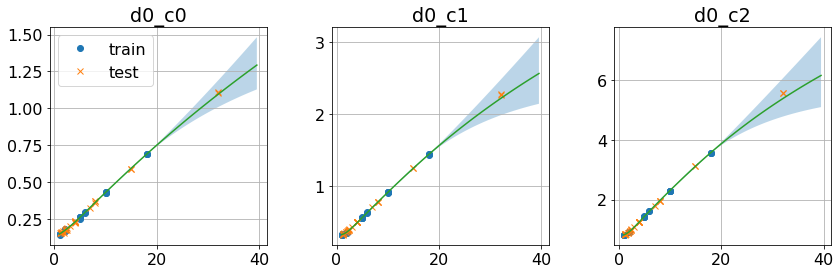

In [31]:
qs_fine = np.arange(1, 40, 0.5)[:,np.newaxis]
cols = df_psf_y_train.columns
ncols = len(cols)
nsamples = len(cols)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(14, 4))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
for i in range(nsamples):
    col = cols[i]
    gp = gps[col]
    
    # generate samples and reverse transformation
    mu_samples = gp.sample_y(np.log(qs_fine), n_samples=100, random_state=0)
    # mu_samples = gp.sample_y(qs_fine, n_samples=100, random_state=0)
    mu_samples = signs_dict[col].values * np.exp(mu_samples)
    mu_test, std_test = gp.predict(np.log(qs_fine), return_std=True)
    # mu_test, std_test = gp.predict(qs_fine, return_std=True)
    mu_test_lower = signs_dict[col].values * np.exp(mu_test-2*std_test)
    mu_test_upper = signs_dict[col].values * np.exp(mu_test+2*std_test)
    mu_test = signs_dict[col].values * np.exp(mu_test)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(df_psf_x_train, df_psf_y_train[col], 'o', label='train')
    ax.plot(df_psf_x_test, df_psf_y_test[col], 'x', label='test')
    ax.plot(qs_fine, mu_test)
    # ax.plot(qs_fine, mu_samples, alpha=0.1, c='k')
    ax.fill_between(qs_fine[:,0], y1=mu_test_lower, y2=mu_test_upper, alpha=0.3)
    
    ax.set_title(col)
    if i == 0:
        ax.legend()
    # plt.axhline(1.5)
    # plt.axvline(32)
    # ax.set_ylim(0,3)
    # ax.set_ylim(0.65, 1)
    # if i == 2:
    #     ax.set_ylim(1, 1.5)
    # ax.set_xlim(15, 20)
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.grid()
    
plt.show()
plt.close()

# model function

In [32]:
# generative phenomenological model (gpm)
def gpm_inspiral_omega_model(t, q, tc, M, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1, sub_dict={}, random_state=None):
    """
    if n_samples = -1 then generate the mean otherwise draw a n_samples
    """
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
    if n_samples == -1:
        mode = "mean"
        n_samples = 1
    else:
        mode = "sample"
    
    t = np.atleast_1d(t)
    eta = phenom.eta_from_q(q)
    log_q = np.log(q)
    
    omega_N, omega_pn = workflow_utils.get_taylort3_inspiral_omega_affine_params(t, tc, eta, M)
    
    theta = pn.TaylorT3_theta(x_sym, tc, eta, M)
    pn_sub_dict = {'x_sym': np.array(theta)}
    ansatz = base_ansatz.subs(pn_sub_dict)
    
    # number of derivatives
    num_d_points = len(collocation_points.keys())
    # number of collocations points for each derivative
    num_c_points = [len(collocation_points[d]) for d in collocation_points.keys()]
    
    rhs = {}
    ## if mean then use the 'predict' method from the GP
    if mode == "mean":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].predict([[log_q]])
                # v = gps[tag].predict([[q]])
                v = np.exp(v)
                v = signs_dict[tag].values * v
                rhs[d].append(np.array([v]))
    ## if sample then use the 'sample_y' method from the GP
    elif mode == "sample":
        for d in range(num_d_points):
            rhs[d] = []
            for c in range(num_c_points[d]):
                tag = f"d{d}_c{c}"
                v = gps[tag].sample_y([[log_q]], n_samples, random_state=random_state)
                # v = gps[tag].sample_y([[q]], n_samples, random_state=random_state)
                v = np.exp(v)
                v = signs_dict[tag].values * v
                rhs[d].append(v.T)
    else:
        raise ValueError(f"mode = {mode} unknown")

    # store a copy
    rhs_ = copy.deepcopy(rhs)
    
    yhats = []
    for n in range(n_samples):
        
        # have to extract the rhs for each sample
        for d in rhs_.keys():
            for i in range(len(rhs_[d])):
                rhs[d][i] = rhs_[d][i][n,0]
                
        cm = collocation.CollocationModel(
            collocation_points=collocation_points,
            rhs=rhs,
            ansatz=ansatz,
            sub_dict=None,
        )
        yhat = cm.predict(t)
        yhat = workflow_utils.transformation_affine_foward(yhat, omega_N, omega_pn)
        yhats.append(yhat)
    
    return np.array(yhats)

# model validation

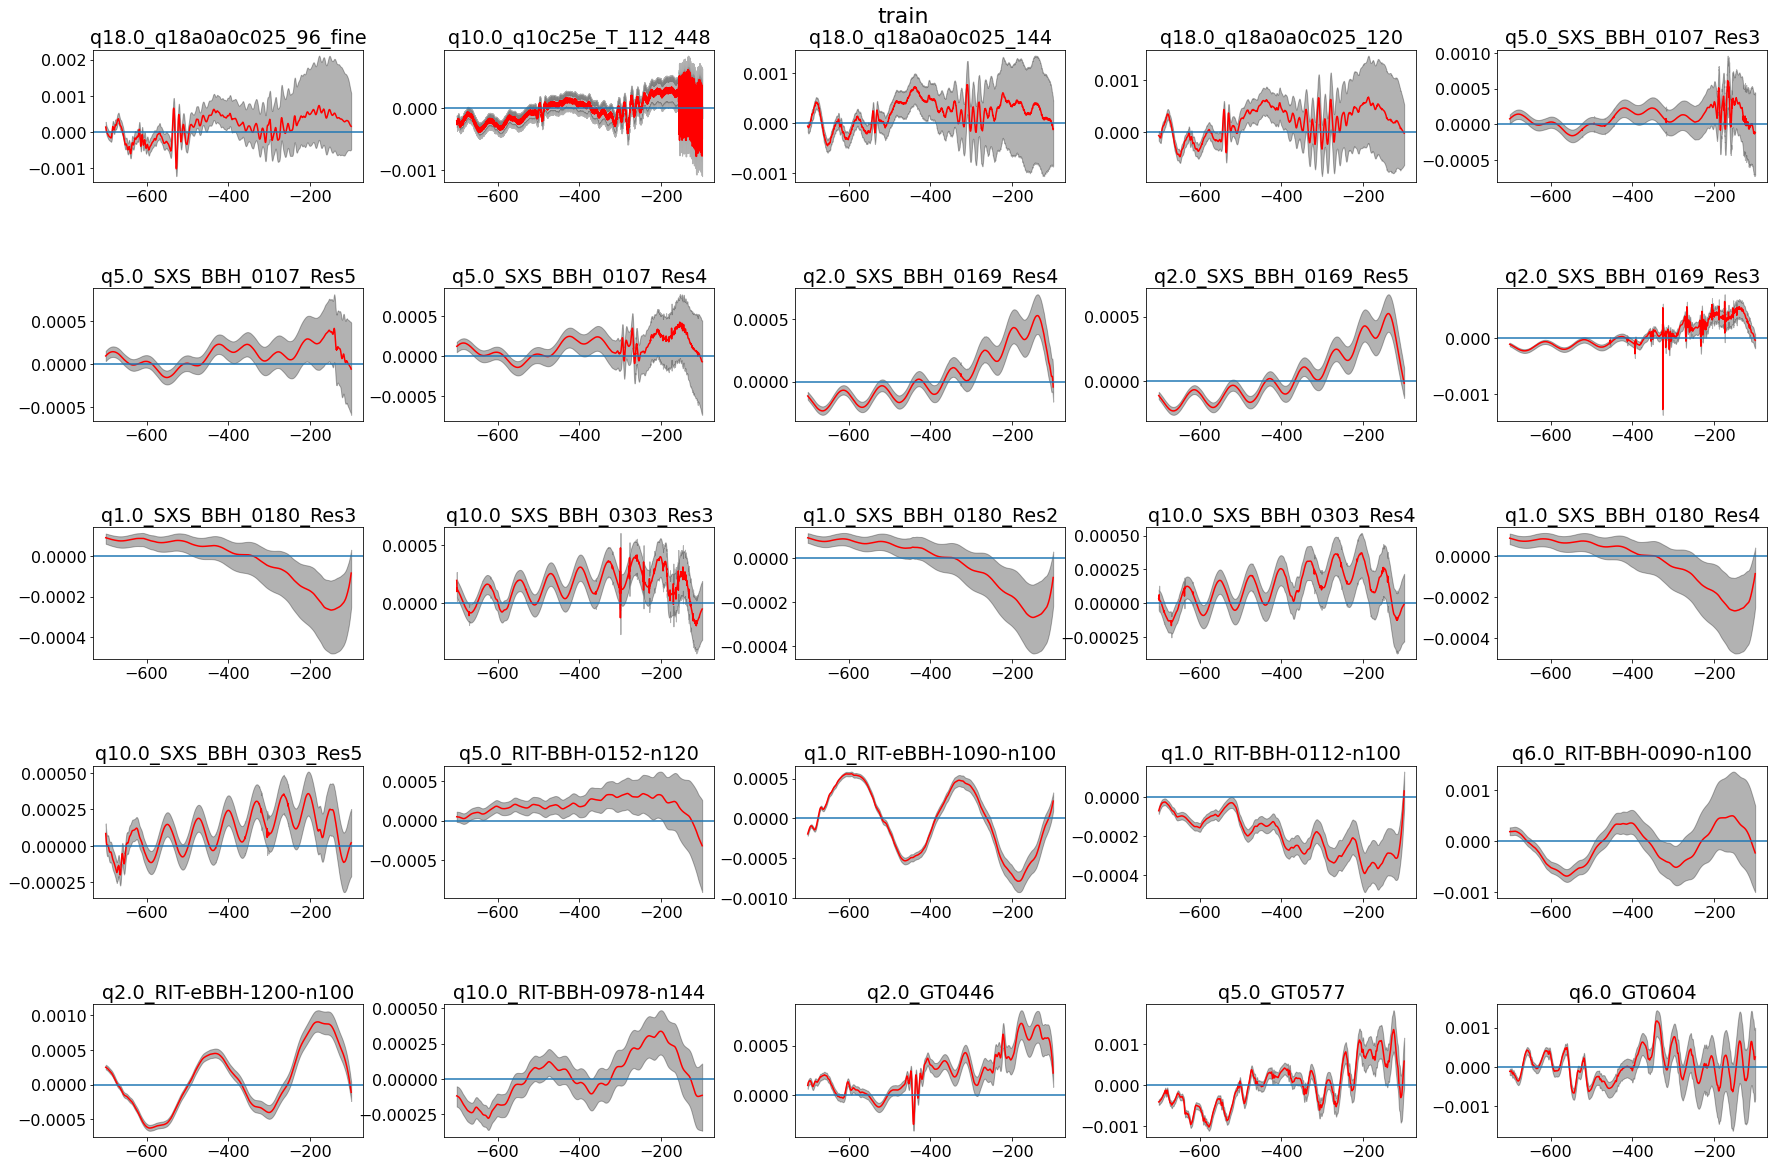

In [33]:
ncols = 5
samples = data_dict['train_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("train", fontsize=22, y=0.91)
    
for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['freqs'][idx]
    ynr = ynr[mask]
    yhats = gpm_inspiral_omega_model(t_star, q_star, tc, M, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
    yhats_samples = gpm_inspiral_omega_model(t_star, q_star, tc, M, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(t_star, ynr-yhats[0], c='r')
    ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    
    ax.axhline(0, c='C0')
    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)

plt.show()
plt.close()

In [34]:
ncols = 5
samples = data_dict['test_idxs']
nsamples = len(samples)
nrows = workflow_utils.get_nrows(ncols, nsamples)

plt.figure(figsize=(30, 20))
plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.suptitle("test", fontsize=22, y=0.91)

for i, idx in enumerate(samples):
    q_star = data_dict['df'].iloc[idx]['q']
    t_star = data_dict['times']
    mask = (t_star >= collocation_points[0][0]) & (t_star <= collocation_points[0][-1])
    t_star = t_star[mask]
    ynr = data_dict['freqs'][idx]
    ynr = ynr[mask]
    yhats = gpm_inspiral_omega_model(t_star, q_star, tc, M, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)
    yhats_samples = gpm_inspiral_omega_model(t_star, q_star, tc, M, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)
    
    ydiff_samples = (ynr - yhats_samples)
    
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.plot(t_star, ynr-yhats[0], c='r')
    ax.fill_between(t_star, y1=ydiff_samples.min(0), y2=ydiff_samples.max(0), color='k', alpha=0.3)
    
    ax.axhline(0, c='C0')
    
    ax.set_title(data_dict['df'].iloc[idx]['tag'])
    
    # ax.set_ylim(-0.001, 0.001)
plt.show()
plt.close()

# save model

In [35]:
components_to_save = {
    "tc":tc,
    "M":M,
    "collocation_points":collocation_points,
    "base_ansatz":base_ansatz,
    "gps":gps,
    "signs_dict":signs_dict,
}

In [36]:
output_filename = os.path.join(OUTPUT_PATH, 'components.cpkl')

In [37]:
output_filename

'/Users/sebastian.khan/personal/data/gpm_model/freq_inspiral_03_03_23/components.cpkl'

In [38]:
# with open(output_filename, "wb") as f:
#     cloudpickle.dump(components_to_save, f)

In [39]:
# with open(output_filename, 'rb') as f:
#     test_c = cloudpickle.load(f)

In [40]:
# test_c.keys()

In [41]:
# tc = test_c["tc"]
# M = test_c["M"]
# collocation_points = test_c["collocation_points"]
# base_ansatz = test_c["base_ansatz"]
# gps = test_c["gps"]
# signs_dict = test_c["signs_dict"]

In [42]:
data_dict['df'].query('q==18')

name     q     fring    fdamp  duration  t_final  \
0  q18a0a0c025_96_fine  18.0  0.063334  0.01414    1020.0    465.8   
6      q18a0a0c025_144  18.0  0.063334  0.01414    1028.3     88.8   
8      q18a0a0c025_120  18.0  0.063334  0.01414    1027.5    174.7   

   start_freq_100Msun    set  has_dup                        tag  
0           26.412409  train     True  q18.0_q18a0a0c025_96_fine  
6           26.822393  train     True      q18.0_q18a0a0c025_144  
8           26.803431  train     True      q18.0_q18a0a0c025_120

In [43]:
# t_star = np.arange(-700, -300, 1)
# t_star = np.arange(-700, -100, 1)
# t_star = np.arange(-2000, -100, 1)
t_star = np.arange(-900, -100, 1)
# q_star = 32

idx = 34
# idx = 8
# idx = 22
# idx = 7
# idx = 33
q_star = data_dict['df']['q'][idx]

In [44]:
q_star

32.0

In [45]:
yhats = gpm_inspiral_omega_model(t_star, q_star, tc, M, collocation_points, base_ansatz, gps, signs_dict, n_samples=-1)

In [46]:
yhats_samples = gpm_inspiral_omega_model(t_star, q_star, tc, M, collocation_points, base_ansatz, gps, signs_dict, n_samples=100)

In [47]:
yhats.shape

(1, 800)

In [48]:
data_dict['df'].iloc[idx]['q']

32.0

In [49]:
t_start

-710

In [50]:
collocation_points

{0: [-700, -300, -100]}

In [51]:
omega_pn = pn.TaylorT3_Omega_GW(t_star, tc, phenom.eta_from_q(q_star), M)

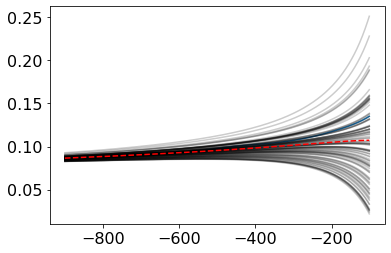

In [52]:
mask = waveforms[idx].times < t_star[-1]
plt.plot(waveforms[idx].times[mask], waveforms[idx].freq[mask], label='data')

plt.plot(t_star, yhats_samples.T, c='k', alpha=0.2);
plt.plot(t_star, yhats[0], c='r', ls='--')

# plt.plot(t_star, omega_pn)


# plt.yscale('log')
# plt.xlim(-800, -100)
# plt.ylim(0.05, 0.3)